In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

In [85]:
img = cv2.imread('clocks/clock2.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [86]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
kp1, des1 = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

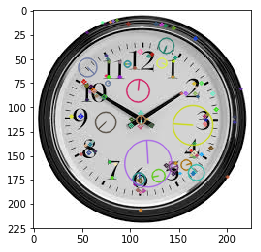

In [87]:
plt.imshow(img, cmap='gray')

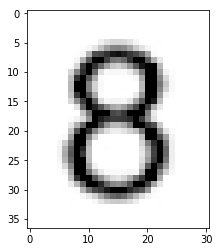

In [104]:
num2 = cv2.cvtColor(cv2.imread('clocks/num8.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(num2, cmap='gray')

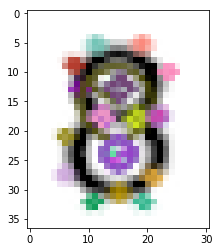

In [105]:
sift2 = cv2.xfeatures2d.SIFT_create()
kp2, des2 = sift2.detectAndCompute(num2,None)
img2=cv2.drawKeypoints(num2,kp2,num2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2, cmap='gray')

In [108]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.knnMatch(des1,des2,k=2)
# Sort them in the order of their distance.
#matches = sorted(matches, key = lambda x:x.distance)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# Draw first 10 matches.
img3 = cv2.drawMatches(img,kp1,img2,kp2,good, None,flags=2)
plt.imshow(img3),plt.show()

error: /opt/concourse/worker/volumes/live/3b96f7c7-93a4-48c6-665d-2f7ff1dac914/volume/opencv_1512680443756/work/modules/core/src/stat.cpp:4044: error: (-215) K == 1 && update == 0 && mask.empty() in function batchDistance
